In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 999)
import timeit

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

In [66]:
df = pd.read_csv('Fire_Dep_Call_50%.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (19,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [67]:
cols = ['Available DtTm', 'Response DtTm', 'Dispatch DtTm', 'Received DtTm']
for col in cols:
    df[col] = pd.to_datetime(df[col], format='%m/%d/%Y %I:%M:%S %p', infer_datetime_format=True)

df['Respond to Available'] = df['Available DtTm'] - df['Response DtTm']
df['Call to Dispatch'] = df['Dispatch DtTm'] - df['Received DtTm']

time_cols = ['Respond to Available', 'Call to Dispatch']
df[time_cols] = df[time_cols].applymap(lambda t: t.total_seconds())
df[time_cols] = df[time_cols].applymap(lambda x: max(x,0))

In [68]:
df['Month'] = df['Received DtTm'].dt.month
df['WeekDay'] = df['Received DtTm'].dt.weekday
df['Weekofyear'] = df['Received DtTm'].dt.weekofyear
df['Hours'] = df['Received DtTm'].dt.hour
df['Minutes'] = df['Received DtTm'].dt.minute

#---------added----------columns for hospital or transport
df['Hospital or Transport'] = (~(df['Transport DtTm'].isna() & df['Hospital DtTm'].isna())).astype('int')

def fill_na(df):
    q = df['Original Priority'].value_counts(normalize=True) #counts share of valeus in col w/o N/A
    orig_prio_list = q.index.tolist()  #makes indeces(priorities types) to a list
    orig_prio_shares = q.tolist() #makes values of shares a list
    df['Original Priority'] = df['Original Priority'].fillna(pd.Series(np.random.choice(orig_prio_list, p=orig_prio_shares, size=len(df))))

    w = df['Call Type Group'].value_counts(normalize=True) #counts share of values in col w/o N/A
    call_types_list = w.index.tolist()  #makes indeces(priorities types) to a list
    call_types_shares = w.tolist() #makes values of shares a list
    df['Call Type Group'] = df['Call Type Group'].fillna(pd.Series(np.random.choice(call_types_list, p=call_types_shares, size=len(df))))
    
fill_na(df)

if((df['Zipcode of Incident'].nunique()) <= (df['Neighborhooods - Analysis Boundaries'].nunique())):
    zipcodes = df[['Neighborhooods - Analysis Boundaries','Zipcode of Incident']]
    zipcodes = zipcodes[zipcodes['Zipcode of Incident'].notnull()]
    zips= list(zipcodes['Zipcode of Incident'].values)
    nbhds= list(zipcodes['Neighborhooods - Analysis Boundaries'].values)
    if len(zips) == len(nbhds):
        zipcodes_dict=dict(zip(nbhds,zips))

    else: 
        print('Count unique zipcodes != count neighborhooods, something went wrong.')
else:
    print('More zipcodes than neighborhooods, we need new strategy!')

df['Zipcode of Incident'] = df['Zipcode of Incident'].fillna(df['Neighborhooods - Analysis Boundaries'].map(zipcodes_dict))
df['Zipcode of Incident'] = df['Zipcode of Incident'].astype(int)

In [6]:
#only not null, not zero and less that 10 hours to solve
df1 = df[(df['Respond to Available'].notnull()) & (df['Respond to Available'] <= 36000) & (df['Respond to Available']!=0)]

In [11]:
df1 = df1.drop(columns=['Call Number','Unit ID', 'Incident Number', 'Call Type Group', 'Call Date', 'Watch Date', 
                      'Received DtTm', 'Entry DtTm', 'Dispatch DtTm','Response DtTm', 'On Scene DtTm',
                      'Transport DtTm','Hospital DtTm', 'Call Final Disposition', 'Available DtTm', 'Minutes',
                      'Supervisor District', 'Neighborhooods - Analysis Boundaries', 'Original Priority','Station Area',
                      'Address', 'City', 'Priority', 'Final Priority',  'Location', 'Month', 'WeekDay', 'Weekofyear',  
                      'RowID', 'Battalion', 'ALS Unit', 'Fire Prevention District'], errors='ignore')

df1 = df1.dropna(how='any') 

In [12]:
df1.head()

,Call Type,Zipcode of Incident,Box,Number of Alarms,Unit Type,Unit sequence in call dispatch,Respond to Available,Call to Dispatch,Hours,Hospital or Transport
1,Medical Incident,94122,7651.0,1,MEDIC,2,4306.0,87.0,21,1
3,Alarms,94102,1456.0,1,ENGINE,3,501.0,26.0,21,0
4,Medical Incident,94108,1322.0,1,RESCUE SQUAD,2,136.0,101.0,21,0
5,Citizen Assist / Service Call,94109,1463.0,1,TRUCK,1,1038.0,43.0,21,0
6,Electrical Hazard,94109,3155.0,1,ENGINE,1,577.0,171.0,21,0


In [13]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2046213 entries, 1 to 2349998
Data columns (total 10 columns):
Call Type                         object
Zipcode of Incident               int64
Box                               float64
Number of Alarms                  int64
Unit Type                         object
Unit sequence in call dispatch    int64
Respond to Available              float64
Call to Dispatch                  float64
Hours                             int64
Hospital or Transport             int64
dtypes: float64(3), int64(5), object(2)
memory usage: 171.7+ MB


In [18]:
dum_list = ['Unit Type', 'Call Type']

for col in dum_list:
    dummies = pd.get_dummies(df1[col], prefix=col, drop_first=False)
    df1[dummies.columns]= dummies

In [20]:
df1= df1.drop(columns=['Unit Type', 'Call Type'])

In [22]:
y = df1['Respond to Available']
X = df1.drop(columns=['Respond to Available'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [23]:
start_time = timeit.default_timer()
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
reg = GradientBoostingRegressor(learning_rate=0.1, n_estimators=50, max_depth=7)
reg.fit(X_train, y_train)

elapsed = timeit.default_timer() - start_time 
print('It took:'+ str(elapsed) + ' seconds to run it.')


It took:753.3600348529872 seconds to run it.


In [24]:
reg.get_params

<bound method BaseEstimator.get_params of GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=7, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=50, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)>

In [25]:
reg.score(X_test, y_test)

0.627792703279336

In [26]:
y_pred = reg.predict(X_test)

In [27]:
XYY = X_test.copy()
XYY['y_test'] = y_test
XYY['y_pred'] = y_pred

XYY

,Zipcode of Incident,Box,Number of Alarms,Unit sequence in call dispatch,Call to Dispatch,Hours,Hospital or Transport,Unit Type_AIRPORT,Unit Type_CHIEF,Unit Type_ENGINE,Unit Type_INVESTIGATION,Unit Type_MEDIC,Unit Type_PRIVATE,Unit Type_RESCUE CAPTAIN,Unit Type_RESCUE SQUAD,Unit Type_SUPPORT,Unit Type_TRUCK,Call Type_Administrative,Call Type_Aircraft Emergency,Call Type_Alarms,Call Type_Assist Police,Call Type_Citizen Assist / Service Call,Call Type_Confined Space / Structure Collapse,Call Type_Electrical Hazard,Call Type_Elevator / Escalator Rescue,Call Type_Explosion,"Call Type_Extrication / Entrapped (Machinery, Vehicle)",Call Type_Fuel Spill,Call Type_Gas Leak (Natural and LP Gases),Call Type_HazMat,Call Type_High Angle Rescue,Call Type_Industrial Accidents,Call Type_Lightning Strike (Investigation),Call Type_Marine Fire,Call Type_Medical Incident,Call Type_Mutual Aid / Assist Outside Agency,Call Type_Odor (Strange / Unknown),Call Type_Oil Spill,Call Type_Other,Call Type_Outside Fire,Call Type_Smoke Investigation (Outside),Call Type_Structure Fire,Call Type_Suspicious Package,Call Type_Traffic Collision,Call Type_Train / Rail Incident,Call Type_Vehicle Fire,Call Type_Water Rescue,Call Type_Watercraft in Distress,y_test,y_pred
1650124,94121,7164.0,1,1,87.0,15,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,936.0,873.830058
1650125,94121,7164.0,1,2,87.0,15,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3200.0,3495.788581
1650126,94102,1365.0,1,3,81.0,15,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,156.0,397.273734
1650127,94103,2251.0,1,1,160.0,15,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,4081.0,3081.607079
1650128,94103,2251.0,1,2,160.0,15,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,150.0,534.185318
1650129,94118,4431.0,1,2,99.0,15,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3297.0,3349.544892
1650132,94107,2244.0,1,3,6.0,15,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,17.0,431.719465
1650133,94107,2244.0,1,2,6.0,15,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,80.0,163.163817
1650134,94114,5175.0,1,2,0.0,15,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3385.0,3104.305635
1650135,94114,5175.0,1,1,0.0,15,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1347.0,726.928017


In [28]:
mean_absolute_error(y_test, y_pred)

620.7433713100716

In [29]:
mean_squared_error(y_test, y_pred) 

1061297.3452829234

In [30]:
scores = -cross_val_score(reg, X_test, y_test, scoring='mean_absolute_error')           

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


In [31]:
scores.mean()

591.5605581746628

In [32]:
feature_importance = reg.feature_importances_

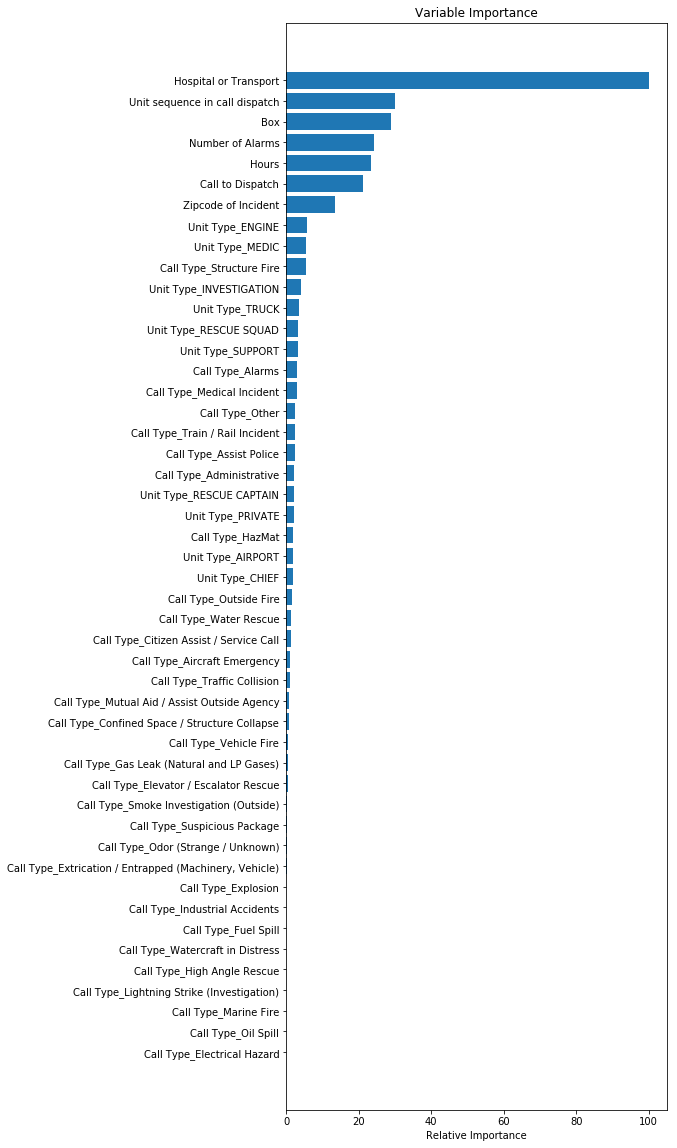

In [46]:
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(15,20))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## RANDOM FOREST

In [ ]:
## RANDOM FOREST

In [37]:
from sklearn.ensemble import RandomForestRegressor

In [38]:
start_time = timeit.default_timer()

RF_regr = RandomForestRegressor(max_depth=5, n_estimators=100)
RF_regr.fit(X_train, y_train)

elapsed = timeit.default_timer() - start_time 
print('It took:'+ str(elapsed) + ' seconds to run it.')

It took:381.2726464930456 seconds to run it.


In [39]:
RF_regr.feature_importances_

array([9.25823573e-05, 1.43677592e-02, 1.52769181e-01, 6.56970620e-03,
       2.25933154e-03, 3.68028696e-03, 7.70902538e-01, 0.00000000e+00,
       0.00000000e+00, 1.74731539e-02, 1.00094769e-02, 5.46587329e-03,
       0.00000000e+00, 0.00000000e+00, 6.20387081e-06, 0.00000000e+00,
       9.04615893e-03, 6.74434766e-03, 0.00000000e+00, 5.05728103e-05,
       7.56903299e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 9.95407759e-06, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.89955959e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.98162443e-06,
       0.00000000e+00, 2.45814726e-04, 0.00000000e+00, 0.00000000e+00,
       7.92879533e-07, 5.75862800e-06, 0.00000000e+00, 0.00000000e+00])

In [40]:
RF_regr.score(X_test, y_test)

0.6012639190000282

In [41]:
y_pred_rf = RF_regr.predict(X_test)
y_pred_rf

array([ 752.78624025, 3461.60455472,  750.50563362, ...,  752.78624025,
        752.78624025,  750.50563362])

In [42]:
mean_absolute_error(y_test, y_pred_rf)

655.7923897698132

In [43]:
mean_squared_error(y_test, y_pred_rf)

1136940.484408008

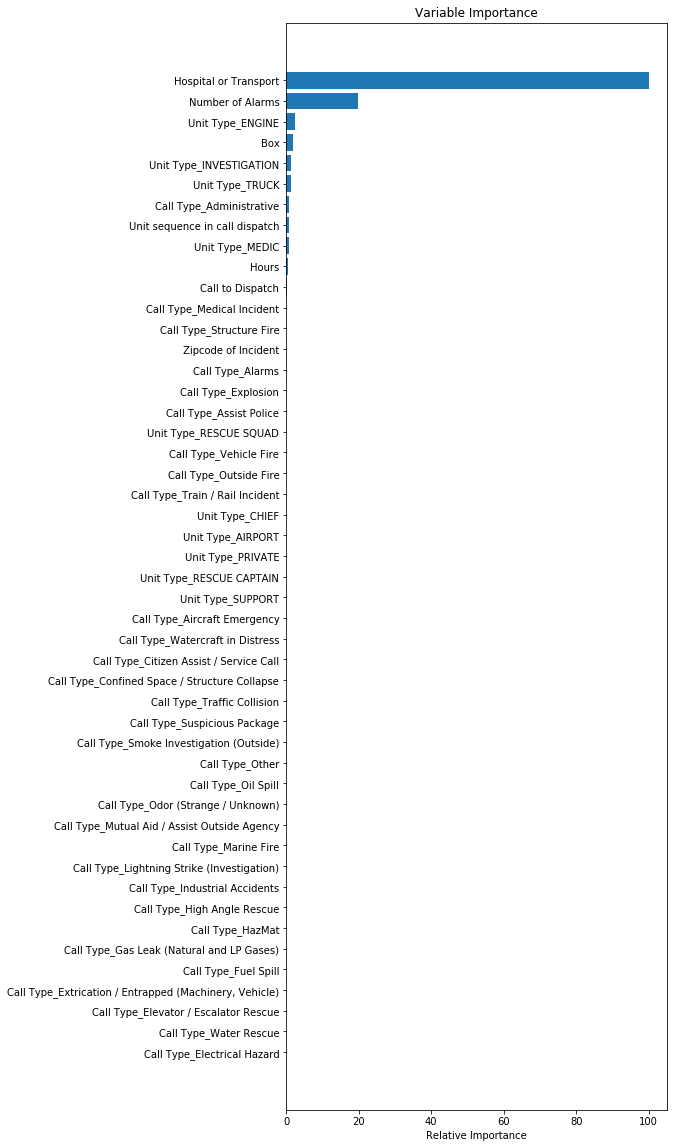

In [45]:
feature_importance_RF = RF_regr.feature_importances_
feature_importance_RF = 100.0 * (feature_importance_RF/ feature_importance_RF.max())
sorted_idx = np.argsort(feature_importance_RF)
plt.figure(figsize=(15,20))
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance_RF[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## XGBOOST

In [47]:
import xgboost
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
import math

In [48]:
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.1, gamma=0, max_depth=7)
xgb.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [49]:
y_pred_xgb = xgb.predict(X_test)
print(explained_variance_score(y_test, y_pred_xgb))

0.638256644937343


In [50]:
xgb.score(X_test,y_test)

0.6313988155227552

In [54]:
print("RMSE: %.2f"
      % (np.mean((xgb.predict(X_test) - y_test) ** 2)))

RMSE: 1051015.02


In [52]:
print(xgb.feature_importances_)

[1.1285963e-01 2.0496234e-01 3.7652057e-02 1.6576560e-01 1.5350454e-01
 1.0619811e-01 1.9984553e-02 3.1859432e-03 1.1488704e-02 1.3129948e-02
 1.1005986e-02 1.2550686e-02 4.8271869e-03 9.5578292e-03 9.3647419e-03
 1.4481560e-02 1.3805754e-02 3.2824869e-03 2.7032245e-03 6.6615175e-03
 6.4684302e-03 3.9582932e-03 2.0274185e-03 9.6543733e-04 1.1585248e-03
 1.9308747e-04 4.8271866e-04 1.4481560e-03 2.3170495e-03 2.8963119e-03
 2.8963119e-04 1.9308747e-03 0.0000000e+00 0.0000000e+00 9.5578292e-03
 1.2550686e-03 4.8271866e-04 3.8617494e-04 8.3027612e-03 5.3099054e-03
 7.7234989e-04 1.3709210e-02 1.7377873e-03 6.7580612e-03 3.5721182e-03
 1.9308747e-03 5.1168180e-03 0.0000000e+00]


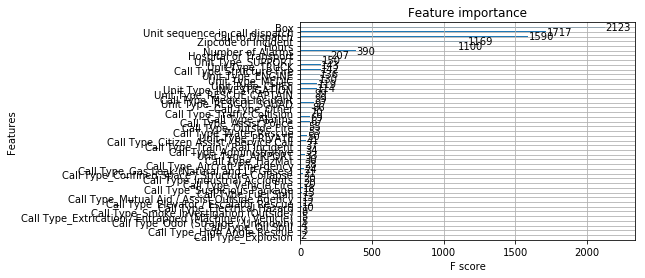

In [59]:
plot_importance(xgb)
plt.figure(figsize=(15,25))
pyplot.show()

# GB WITH DROPED FIRST DUMMIES

In [69]:
#only not null, not zero and less that 10 hours to solve
df2 = df[(df['Respond to Available'].notnull()) & (df['Respond to Available'] <= 36000) & (df['Respond to Available']!=0)]

In [70]:
df2 = df2.drop(columns=['Call Number','Unit ID', 'Incident Number', 'Call Type Group', 'Call Date', 'Watch Date', 
                      'Received DtTm', 'Entry DtTm', 'Dispatch DtTm','Response DtTm', 'On Scene DtTm',
                      'Transport DtTm','Hospital DtTm', 'Call Final Disposition', 'Available DtTm', 'Minutes',
                      'Supervisor District', 'Neighborhooods - Analysis Boundaries', 'Original Priority','Station Area',
                      'Address', 'City', 'Priority', 'Final Priority',  'Location', 'Month', 'WeekDay', 'Weekofyear',  
                      'RowID', 'Battalion', 'ALS Unit', 'Fire Prevention District'], errors='ignore')

df2 = df2.dropna(how='any') 

In [71]:
df2.head()

,Call Type,Zipcode of Incident,Box,Number of Alarms,Unit Type,Unit sequence in call dispatch,Respond to Available,Call to Dispatch,Hours,Hospital or Transport
1,Medical Incident,94122,7651.0,1,MEDIC,2,4306.0,87.0,21,1
3,Alarms,94102,1456.0,1,ENGINE,3,501.0,26.0,21,0
4,Medical Incident,94108,1322.0,1,RESCUE SQUAD,2,136.0,101.0,21,0
5,Citizen Assist / Service Call,94109,1463.0,1,TRUCK,1,1038.0,43.0,21,0
6,Electrical Hazard,94109,3155.0,1,ENGINE,1,577.0,171.0,21,0


In [75]:
dum_list = ['Unit Type', 'Call Type']

for col in dum_list:
    dummies = pd.get_dummies(df2[col], prefix=col, drop_first=True)
    df2[dummies.columns]= dummies

In [76]:
df2= df2.drop(columns=['Unit Type', 'Call Type'])

In [77]:
y = df2['Respond to Available']
X = df2.drop(columns=['Respond to Available'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [78]:
start_time = timeit.default_timer()
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
reg = GradientBoostingRegressor(learning_rate=0.1, n_estimators=50, max_depth=7)
reg.fit(X_train, y_train)

elapsed = timeit.default_timer() - start_time 
print('It took:'+ str(elapsed) + ' seconds to run it.')


It took:705.1800048369914 seconds to run it.


In [79]:
reg.get_params

<bound method BaseEstimator.get_params of GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=7, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=50, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)>

In [80]:
reg.score(X_test, y_test)

0.6288889463547996

In [81]:
y_pred = reg.predict(X_test)

In [82]:
XYY = X_test.copy()
XYY['y_test'] = y_test
XYY['y_pred'] = y_pred

XYY.head()

,Zipcode of Incident,Box,Number of Alarms,Unit sequence in call dispatch,Call to Dispatch,Hours,Hospital or Transport,Unit Type_CHIEF,Unit Type_ENGINE,Unit Type_INVESTIGATION,Unit Type_MEDIC,Unit Type_PRIVATE,Unit Type_RESCUE CAPTAIN,Unit Type_RESCUE SQUAD,Unit Type_SUPPORT,Unit Type_TRUCK,Call Type_Aircraft Emergency,Call Type_Alarms,Call Type_Assist Police,Call Type_Citizen Assist / Service Call,Call Type_Confined Space / Structure Collapse,Call Type_Electrical Hazard,Call Type_Elevator / Escalator Rescue,Call Type_Explosion,"Call Type_Extrication / Entrapped (Machinery, Vehicle)",Call Type_Fuel Spill,Call Type_Gas Leak (Natural and LP Gases),Call Type_HazMat,Call Type_High Angle Rescue,Call Type_Industrial Accidents,Call Type_Lightning Strike (Investigation),Call Type_Marine Fire,Call Type_Medical Incident,Call Type_Mutual Aid / Assist Outside Agency,Call Type_Odor (Strange / Unknown),Call Type_Oil Spill,Call Type_Other,Call Type_Outside Fire,Call Type_Smoke Investigation (Outside),Call Type_Structure Fire,Call Type_Suspicious Package,Call Type_Traffic Collision,Call Type_Train / Rail Incident,Call Type_Vehicle Fire,Call Type_Water Rescue,Call Type_Watercraft in Distress,y_test,y_pred
1650123,94116,7714.0,1,1,143.0,15,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3266.0,3827.786887
1650124,94121,7164.0,1,1,87.0,15,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,936.0,871.122120
1650125,94121,7164.0,1,2,87.0,15,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3200.0,3475.059417
1650126,94102,1365.0,1,3,81.0,15,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,156.0,365.392858
1650127,94103,2251.0,1,1,160.0,15,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,4081.0,3081.419911


In [83]:
mean_absolute_error(y_test, y_pred)

619.2253488817422

In [84]:
mean_squared_error(y_test, y_pred) 

1058171.5514433484

In [86]:
scores = -cross_val_score(reg, X_test, y_test, scoring='mean_absolute_error')           

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


KeyboardInterrupt: 

In [ ]:
scores.mean()

In [87]:
feature_importance = reg.feature_importances_

In [88]:
feature_importance 

array([4.38888545e-02, 1.15971027e-01, 8.30601647e-02, 9.20077809e-02,
       7.47203779e-02, 6.74890354e-02, 3.34027906e-01, 5.94218381e-03,
       2.02131970e-02, 1.31464518e-02, 1.20716940e-02, 4.31921968e-03,
       7.11091307e-03, 1.00453547e-02, 9.72613355e-03, 1.25807511e-02,
       3.85427491e-03, 1.07525496e-02, 7.06918017e-03, 3.90933276e-03,
       1.27364823e-03, 0.00000000e+00, 7.85618031e-04, 1.14880299e-04,
       2.84902573e-04, 4.14307649e-05, 1.59520404e-03, 6.13317727e-03,
       0.00000000e+00, 4.55562170e-05, 0.00000000e+00, 0.00000000e+00,
       9.90560342e-03, 1.68756546e-03, 2.22678418e-04, 0.00000000e+00,
       8.38524582e-03, 6.08772625e-03, 0.00000000e+00, 1.33234234e-02,
       1.18634649e-03, 3.41622065e-03, 5.62557703e-03, 1.72380904e-03,
       6.25500364e-03, 0.00000000e+00])

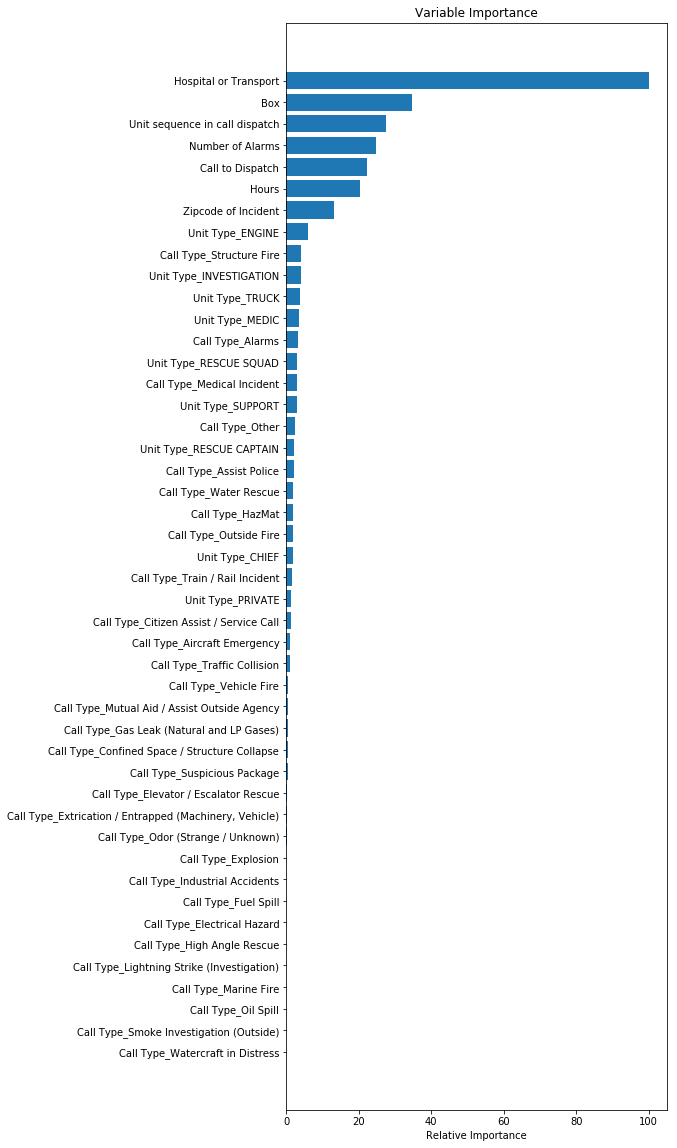

In [89]:
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(15,20))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()